we experimented with the target columns i.e. we have 6 target classes, we assigned a new label based on the unique combination of labels that we see in these label values i.e. we will have 64 combinations.

In [ ]:
!pip install transformers==2.3.0

In [ ]:
# from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.notebook import tqdm
import os
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Loading the data

In [ ]:
def getpreferredencoding(do_setlocale = True):
  return "UTF-8"
import locale
locale.getpreferredencoding = getpreferredencoding

In [ ]:
path = '/content/drive/MyDrive/Capstone Data/Phase 2/final_data.pkl'
train_df = pd.read_pickle(path, compression = 'gzip')

features = ['sentence_count', 'word_count', 'unique_word_count', 
            'length', 'punctuation_count', 'upper_case_count', 
            'stopword_count', '#_count', 'unique_word_count_percent', 
            'Punctuation_percent', 'ip_count','link_count', 
            'article_id_count', 'username_count', 'clean_comment']

target_cols = ['toxic', 'severe_toxic', 'obscene', 'threat',
               'insult', 'identity_hate']
train_df = train_df.dropna()

# Seperating features and target variable
x = train_df[features]
y = train_df[target_cols]


In [ ]:
# Converting combination of y label to single value by considering a unique label 
# value for each combination of the labels present
unique_combinations = (y.drop_duplicates().reset_index(drop=True))
print("Number of Unique Combinations: ", len(unique_combinations))
unique_combinations = unique_combinations.reset_index()
y = pd.merge(y, unique_combinations,  how='left', left_on =target_cols, right_on = target_cols)['index']

Number of Unique Combinations:  41


Text(0, 0.5, 'Count')

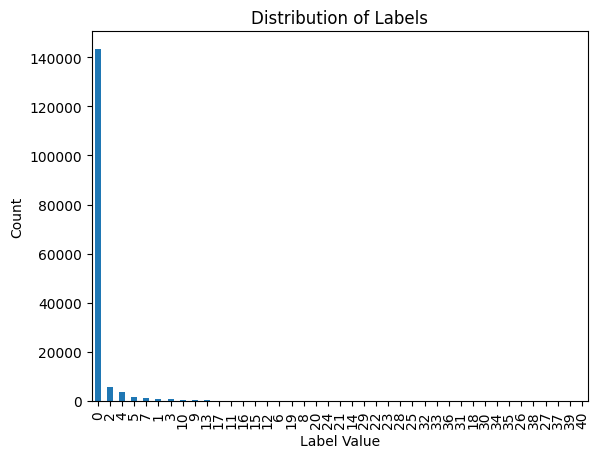

In [ ]:
ax = y.value_counts().plot(kind='bar', title='Distribution of Labels')

ax.set_xlabel("Label Value")
ax.set_ylabel("Count")

As expected majority of the comments are non toxic thus fall under 0th label

Text(0, 0.5, 'Count')

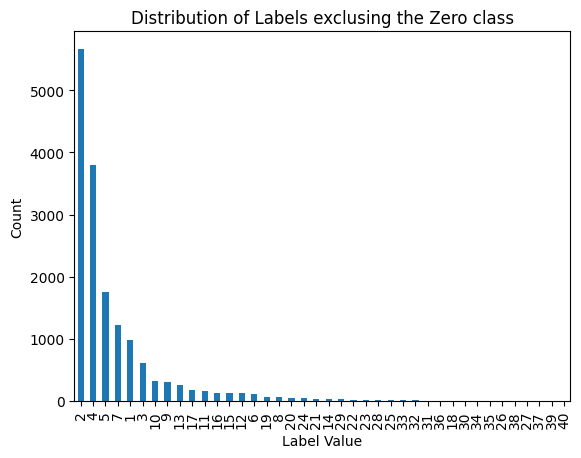

In [ ]:
# Looking more closely at the class distribution excluding the zero class
ax = y[y!=0].value_counts().plot(kind='bar', title='Distribution of Labels exclusing the Zero class')

ax.set_xlabel("Label Value")
ax.set_ylabel("Count")

#### Supporting Functions

In [ ]:
def evaluation_metrics(y_test, y_pred):
    result = {}
    result['Accuracy'] = accuracy_score(y_test, y_pred)
    result['Precision'] = precision_score(y_test, y_pred, average='weighted')
    result['Recall'] = recall_score(y_test, y_pred, average='weighted')
    result['F1 Score'] = f1_score(y_test, y_pred, average='weighted')
    return result

# BERT Encoding

In [ ]:
from transformers import BertTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

bert_model_name = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(bert_model_name, do_lower_case=True)
MAX_LEN = 128

def tokenize_sentences(sentences, tokenizer, max_seq_len = 128):
    tokenized_sentences = []

    for sentence in tqdm(sentences):
        tokenized_sentence = tokenizer.encode(
                            sentence,                  # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_seq_len,  # Truncate all sentences.
                    )
        
        tokenized_sentences.append(tokenized_sentence)

    return tokenized_sentences

def create_attention_masks(tokenized_and_padded_sentences):
    attention_masks = []

    for sentence in tokenized_and_padded_sentences:
        att_mask = [int(token_id > 0) for token_id in sentence]
        attention_masks.append(att_mask)

    return np.asarray(attention_masks)

input_ids = tokenize_sentences(x['clean_comment'], tokenizer, MAX_LEN)
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
attention_masks = create_attention_masks(input_ids)

  0%|          | 0/159571 [00:00<?, ?it/s]

In [ ]:
features.remove('clean_comment')

In [ ]:
merged_x = np.hstack((attention_masks, np.array(x[features])))
merged_x.shape

(159571, 142)

In [ ]:
# Splitting the data into train and test dataset
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(np.array(merged_x), np.array(y), 
                                            test_size = 0.2, random_state = 2)

In [ ]:
no_rows = train_x.shape[0]
no_cols = train_x.shape[1]

#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=0).fit(train_x, train_y)
pred = model.predict(test_x)
res = evaluation_metrics(test_y,pred)
res

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 0.8974463418455272,
 'Precision': 0.816854051454178,
 'Recall': 0.8974463418455272,
 'F1 Score': 0.8506985338393765}

#### Gaussian NB

In [ ]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(train_x, train_y)
pred = clf.predict(test_x)
res = evaluation_metrics(test_y,pred)
res

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 0.002036659877800407,
 'Precision': 0.8390868270443158,
 'Recall': 0.002036659877800407,
 'F1 Score': 0.003713474476017509}

#### Decision Tree

In [ ]:
from warnings import resetwarnings
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(train_x, train_y)
pred = clf.predict(test_x)
res = evaluation_metrics(test_y,pred)
res

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 0.8109352968823437,
 'Precision': 0.8247276461013041,
 'Recall': 0.8109352968823437,
 'F1 Score': 0.817732553685974}

# TF-IDF 

In [ ]:
path = '/content/drive/MyDrive/Capstone Data/Phase 2/final_data.pkl'
train_df = pd.read_pickle(path, compression = 'gzip')

features = ['sentence_count', 'word_count', 'unique_word_count', 
            'length', 'punctuation_count', 'upper_case_count', 
            'stopword_count', '#_count', 'unique_word_count_percent', 
            'Punctuation_percent', 'ip_count','link_count', 
            'article_id_count', 'username_count', 'clean_comment']

target_cols = ['toxic', 'severe_toxic', 'obscene', 'threat',
               'insult', 'identity_hate']
train_df = train_df.dropna()

# Seperating features and target variable
x = train_df[features]
y = train_df[target_cols]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def tf_idf(X_train):
  vectorizer = TfidfVectorizer(max_features = 500)
  X_train_tfidf = vectorizer.fit_transform(X_train)
  
  return X_train_tfidf

In [ ]:
tf_idf_data = tf_idf(train_df['clean_comment']).toarray()

In [ ]:
features.remove('clean_comment')

In [ ]:
merged_x = np.hstack((tf_idf_data, np.array(x[features])))
merged_x.shape

(159571, 514)

In [ ]:
# Converting combination of y label to single value by considering a unique label 
# value for each combination of the labels present
unique_combinations = (y.drop_duplicates().reset_index(drop=True))
print("Number of Unique Combinations: ", len(unique_combinations))
unique_combinations = unique_combinations.reset_index()
y = pd.merge(y, unique_combinations,  how='left', left_on =target_cols, right_on = target_cols)['index']

Number of Unique Combinations:  41


In [ ]:
# Splitting the data into train and test dataset
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(np.array(merged_x), np.array(y), 
                                            test_size = 0.2, random_state = 2)

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=0).fit(train_x, train_y)
pred = model.predict(test_x)
res = evaluation_metrics(test_y,pred)
res

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 0.8973836753877487,
 'Precision': 0.8182948313721226,
 'Recall': 0.8973836753877487,
 'F1 Score': 0.8505530362779073}

### Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(train_x, train_y)
pred = clf.predict(test_x)
res = evaluation_metrics(test_y,pred)
res

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 0.3551621494595018,
 'Precision': 0.8912426506762338,
 'Recall': 0.3551621494595018,
 'F1 Score': 0.5054705323401433}

### Decision tree

In [ ]:
from warnings import resetwarnings
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(train_x, train_y)
pred = clf.predict(test_x)
res = evaluation_metrics(test_y,pred)
res

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 0.8678677737740874,
 'Precision': 0.8644416840367201,
 'Recall': 0.8678677737740874,
 'F1 Score': 0.8661031332625024}

 The model performed poorly for Naive Bayes. We see that Logistic Regression and Decision trees performed fairly well even in this scenario, however logically this approach might not always work well as this depends on the dataset being used and the relationship between the types of toxicities observed. For the dataset that we used, we had previously observed that there exists strong correlation between the toxicity types, thus it seems like our models seem to perform well as they are able to understand this correlation to make better predictions. 